# Lasso & Elastic Net

# Sparse models for variable selection

The goal of this lab is to familiarize with the concept of *sparsity* and to see its connection with the selection of variables in high dimensional contexts.

A machine learning model is said to be **sparse** when it only contains a small number of non-zero parameters, with respect to the number of features that can be measured on the objects this model represents.

Let's see how sparsity works in practice.

## 1. *Sparse* variable selection on toy problems

Using `scikit-learn` let's make a toy regression problem with `n=100` samples and `d=30` variables of which only `d_rel=5` are informative. Use the flag `coef=True` to get $w^*$, *ie* the **real** weights of the toy problem.

In [82]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso, Ridge, ElasticNet,lars_path,enet_path

In [67]:
n = 100
d = 30
d_rel = 7

X_1, y_1, coef = make_regression(n_samples=n, n_features=d, n_informative=d_rel, noise=20, coef=True, random_state=0)
print("Data shape: {}".format(X.shape))

Data shape: (100, 30)


Let's now perform sparse linear regression fitting a [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) model

$$\min_w \frac{1}{2 n} ||y - Xw||^2_2 + \alpha~||w||_1$$

for a fixed value of $\alpha=40$.

In [68]:
mdl = Lasso(alpha=40)
mdl.fit(X_1, y_1)

Lasso(alpha=40)

We can inspect the value of the weights $w$ by checking `mdl.coef_`, let's plot their value on a 2D space and let's compare them with $w^*$. 

**Comment the results.**

In [13]:
mdl.coef_

array([-0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       49.03513239, -0.        , 35.88621526,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  8.52212722, -0.        , 46.67496486,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ])

In [7]:
# The model coefficients are mostly zero. There are only 4 values that are not zero. So basically what alpha does is 
# that its elimininating some features. Theoeretically as you increase alpha then you will drop more features.
# Setting the value of alpha to 40 as in the previous example means that we are looking for a much more sparse
# solution. 

### Try to play a bit with the value of $\alpha$.

**What do you expect?**

**What happens?**

**What can you say about the choice of setting $\alpha=40$ in the previous example?**

## 2. Recap on the regularization path

We sensed that the role played by the regularization parameter $\alpha$ is crucial. When performing variable selection in high-dimensional contexts it may be helpful to observe the weight assigned to each variable for increasing values of $\alpha$.

An intuitive representation of such phenomenon is called **`regularization path`**

### 2.1 Hands on the Lasso path

**With the toy regression problem above, implement a function that estimates the `lasso path` and visualize it.**

.

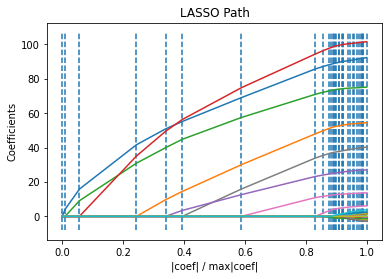

In [69]:
# There are several ways to do this task am going ot use lars_path as below. 

def lassopath(X,y):
    alphas, _ , coefs=lars_path(X, y, method='lasso', verbose=True)
    xvals = np.sum(np.abs(coefs.T), axis=1)
    xvals /= xvals[-1]
    
    plt.plot(xvals, coefs.T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('LASSO Path')
    plt.axis('tight')
    plt.show()
    
lassopath(X_1,y_1)

**Implement a function that estimates the `ridge path`.Compare your results and comment differences**

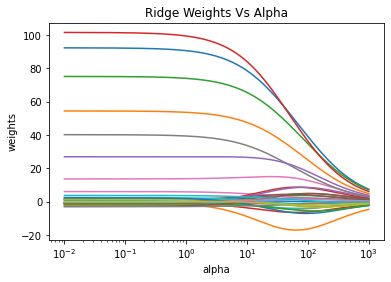

In [75]:
def rigdgecoefs(X,y):
    n_alphas = 300
    alphas = np.logspace(-2,3 , n_alphas)
    coefs = []
    for i in alphas:
        ridge = Ridge(alpha=i, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_)
        
    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log') 
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Ridge Weights Vs Alpha')
    plt.axis('tight')
    plt.show()
        
rigdgecoefs(X_1,y_1)
#As alphas tend to become bigger the weights on the other hand tend to become small and get to zero for Ridge.
#So in otherwards the features are shrunk though not kicked out. 

### 2.2 Lasso and correlations among features

In presence of correlation between variables, the lasso penalty may not be very informative. Let's try to evaluate it on a toy dataset in which each informative variable is repeated twice.

Use `n=100` samples, `half_d_rel=5`, `d_dummy = 25`.

In [78]:
n = 100
half_d_rel = 5
d = 30
d_dummy = d - half_d_rel

X_2, y_2, coef = make_regression(n_samples=n, n_features=d-half_d_rel, n_informative=half_d_rel, coef=True)
relevant = np.nonzero(coef)[0]
X_2 = np.hstack((X_2, -2*X_2[:,relevant]))

print("Data shape: {}".format(X_2.shape))

Data shape: (100, 30)


**The total number of relevant variables here is `2*half_d_rel = 10`.**

**Use the function implemented in Exercise #2.1 and visualize the lasso path for this dataset.**

.

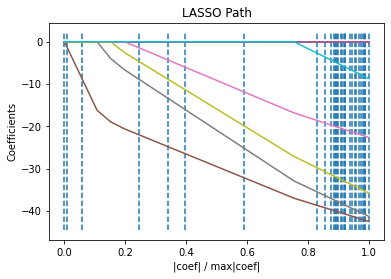

In [79]:
lassopath(X_2,y_2)

**How many selected variable do you see? Why?**

In [80]:
#From the the second dataset the chosen features are 5. The others have been dropped. This is because for lasso 
# alpha is zero or then all the least squares are not going to be regularized but as it increases then some 
# features are going to be dropped. The most relevant features are going to be returned. 

## `Elastic-Net` model :

$$\min_w \frac{1}{2n} ||y - Xw||^2_2 + \alpha \cdot l_{1_{ratio}} \cdot ||w||_1 + \frac{1}{2}~\alpha \cdot (1 - l_{1_{ratio}}) \cdot ||w||^2_2$$

or equivalently as:

$$\min_w \frac{1}{2n} ||y - Xw||^2_2 + \tau~||w||_1 + \mu~||w||^2_2$$

with appropriate parameters formulation.
The Elastic-Net, thanks to the combined influence of the $\ell_1$ and the $\ell_2$-norm, achieves a sparse and stable solution in which joint selection of collinear variables is promoted.

**Fix the `l_1ratio=0.5` and evaluate the Elastic-Net path on the datasets of Exercise 2.2**

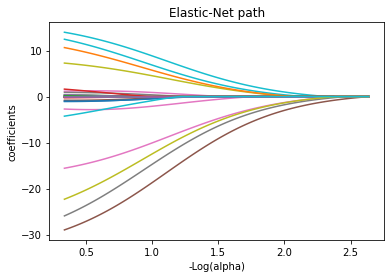

In [117]:
def elasticnet_path(X,y):
    eps = 5e-3
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=0.5, fit_intercept=False)
    count = 0
    for i in coefs_enet:
        
        l1 = plt.plot(np.log10(alphas_enet),i)
        count = count+1
        
    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Elastic-Net path')
    plt.axis('tight')
    plt.show()
    
elasticnet_path(X_2,y_2)

**How many selected variable do you see? Why?**

**Which is the asymptotic behavior of the weights corresponding to correlated features?**

In [118]:
# The selected variables depend on the choice of alpha, between 0.5 and 2.5 alpha there are different variables 
# higlighted. At 0.5 a good amount of the features are selected but the more we move further and get alpha to increase
# that number decreases. Some features go to zero and others are dropped. 

In [124]:
"""Feature selection and classification by linear two steps model."""

from sklearn.linear_model import ElasticNet
from sklearn.linear_model.base import LinearClassifierMixin
#sklearn.base.ClassifierMixin[source]
from sklearn.preprocessing import LabelBinarizer
# from sklearn.utils import column_or_1d


class ElasticNetClassifier(LinearClassifierMixin, ElasticNet):
    """Class to extend elastic-net in case of classification."""

    def fit(self, X, y, check_input=True):
        self._label_binarizer = LabelBinarizer(pos_label=1, neg_label=-1)
        Y = self._label_binarizer.fit_transform(y)
        if self._label_binarizer.y_type_.startswith('multilabel'):
            # we don't (yet) support multi-label classification in ENet
            raise ValueError(
                "%s doesn't support multi-label classification" % (
                    self.__class__.__name__))

        # Y = column_or_1d(Y, warn=True)
        super(ElasticNetClassifier, self).fit(X, Y)
        if self.classes_.shape[0] > 2:
            ndim = self.classes_.shape[0]
        else:
            ndim = 1
        self.coef_ = self.coef_.reshape(ndim, -1)

        return self

    @property
    def classes_(self):
        return self._label_binarizer.classes_

0.24.1


# 3 Elastic-net for variable selection in Microarray study

**We will train an ElasticNetClassifier (take a look at the file `enet_classifier.py`) on the [Golub dataset](http://portals.broadinstitute.org/cgi-bin/cancer/publications/pub_paper.cgi?paper_id=43) which contains microarray data measured from two classes of leukemia: acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).**

In [120]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#from enet_classifier import ElasticNetClassifier

ModuleNotFoundError: No module named 'sklearn.linear_model.base'

### 3.1. Load data

Let's load the dataset with `pandas` in the usual way (`pandas.read_csv`). Read both data and labels.

In [125]:
data = pd.read_csv("gedm.csv", header=0, index_col=0).T
print("n_samples = {} | n_variables = {}".format(*data.shape))

n_samples, n_variables = data.shape
data.head()

n_samples = 38 | n_variables = 7129


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [ ]:
labels = pd.read_csv('labels.csv', header=0, index_col=0)
print("n_samples (AML) = {} | n_samples (ALL) = {}".format(
    np.sum(labels.values == 'AML'), np.sum(labels.values == 'ALL')))

labels.head()

**Encode the labels into the standard binary classification problem: associate ALL with class `1` and AML with class `-1`.**

In [ ]:
binary_labels = np.where(labels.values == 'ALL', 1, -1)

**What is the accuracy score of a random classifier?**

**Note that some columns of `data` start with `AFFX`. These are not real features. Instead, they are some control probes related to the microarray structure. For this reason, we can remove them before the actual analysis.**

In [ ]:
relevant_features = data.columns[~data.columns.str.startswith("AFFX")]
data = data.loc[:, relevant_features]

### 3.2. Data visualization

**We can visualize the data by projecting them on a 2-dimensional space with `PCA`.**

### 3.3 Fitting the model

To control separately $\mu$ and $\tau$ in the ElasticNet model, you need to solve the appropriate linear system of equationa.

$ \alpha l_{1_{ratio}} = \tau$

$ \frac{\alpha}{2} (1 - l_{1_{ratio}}) = \mu$

$\dots$

$ l_{1_{ratio}} = \frac{\tau}{2 \mu + \tau}$

$ \alpha = 2 \mu + \tau$



**Write a Python function which performs the conversion from `tau` and `mu` to `alpha` and `l1_ratio`.**

### 3.4 Nested variable selection

We will observe the effect of increasing the value of `mu`, which controls the amount of variable correlation tolerated in the solution. For example, with fixed `tau`, increasing `mu` should result in selecting nested list of variables, as in [DeMol09](http://online.liebertpub.com/doi/abs/10.1089/cmb.2008.0171).

**Implement a data analysis pipeline following the next steps:**

1. Fix a value for `mu_0`, *e.g.* `mu_0 = 1`.

2. Split the dataset into `K` folds (non-overlapping groups).

    a. For each iteration keep $\frac{1}{K}$ samples aside and use it as test set.
    
    b. Use the remaining $\frac{K-1}{K}$ samples and use them as training set to optimize the regularization parameter `tau` via an inner `GridSearch` cross-validation.
    
    c. The best model is achieved with the optimal `tau` fitted on the training set.

    d. Evaluate the best model on the test set and keep track of the accuracy score and the list of selected variables.
    
This would allow us to obtain a ranking of variables.

In [ ]:
X, y = #training data, labels

#Find an appropriate number of folds in which split the dataset
K = #?

kf = StratifiedKFold(n_splits=K, shuffle=True)

enet = ElasticNetClassifier()

Use the following ranges for the parameters:
- `tau_range` in logarithmic scale from `1e-1` to `1e5`
- `mu_range` as [`1e4`, `1e5`, `1e7`, `1e8`]

### 3.5 Build a `pandas` DataFrame whose values correspond to the number of times each variable is selected for different values of $\mu$

### 3.6 Build an explanatory visualization of the selection frequency for each variable, at different choices of $\mu$

**What do you observe?**